In [27]:
import glob
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from matplotlib.pyplot import *

import pysftp
from getpass import getpass

import os

from nicer.kcg import mkfwork as m

rcParams['text.usetex']=False


# Examining the background spectrum library

KCG accumulated spectra from the background events files, in KP/COR_SAX bins. 
We want our python code to determine which spectral files matches the KP/COR_SAX from the observation, and weight by the fraction of 
overall events (or some appropriate weighting)


## Finding parameter bins

for a given set of parameters (COR, KP, for example), we need to select the correct library file appropriate for those parameters

if we find a library file, if the number of counts is not greater than minbkg, the minimum acceptable number of counts, find the correct library file appropriate for those parameters from the COARSE binned library


In [2]:
libdir = '/Volumes/SXDC/Data/NICER/kp_model/gen12/bkg_spec/20181025'
params=['cor','kp']
minbkg=15000

In [3]:
lDF = m.mk_bkgspecDF(params,libdir=libdir, getdata=False)

In [4]:
lDF.tail(3)

,file,cormin,cormax,kpmin,kpmax
425,cor9.75_10.0_kp3.5_4.5.pha,9.75,10.0,3.5,4.5
426,cor9.75_10.0_kp4.5_5.5.pha,9.75,10.0,4.5,5.5
427,cor9.75_10.0_kp5.5_6.5.pha,9.75,10.0,5.5,6.5


In [5]:
c = 3.5
k = 1.2

p=params[0]

l1 = lDF[lDF['{p}min'.format(p=p)] <= c]
l2 = l1[l1['{p}max'.format(p=p)] >= c]
l3 = l2[l2['{p}min'.format(p='kp')] <= k]
l4 = l3[l3['{p}max'.format(p='kp')] >= k]

In [6]:
l4

,file,cormin,cormax,kpmin,kpmax
239,cor3.25_3.5_kp0.5_1.5.pha,3.25,3.50,0.5,1.5
246,cor3.5_3.75_kp0.5_1.5.pha,3.50,3.75,0.5,1.5


## Finding the correct library file for a give set of pvals

In [63]:
# given parameters c, k find the library background spectrum file
c = 3.5
k = 1.2
ltest = lDF
pval = {'cor':c, 'kp':k}
for p in params:
    ltest = ltest[ltest['{p}min'.format(p=p)] <= pval[p]]
    ltest = ltest[ltest['{p}max'.format(p=p)] >= pval[p]]
libfile = ltest['file'].values[0]

In [64]:
hdu = fits.open(os.path.join(libdir,libfile))
spec_cts = hdu['SPECTRUM'].data.COUNTS.sum()

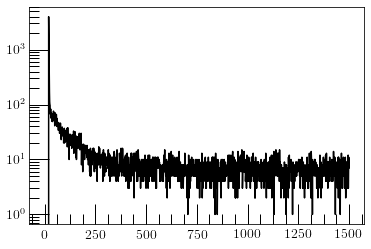

In [65]:
if spec_cts > minbkg:
    yscale('log')
    plot(hdu['SPECTRUM'].data.CHANNEL, hdu['SPECTRUM'].data.COUNTS)

## We now want to interpolate the spectrum over the first parameter

(since we only have a coarse COR library)

so for a given set of pvals, we need to
* compare each c value with cmid, the midpoint of the library file cor bin
* if c > cmid, interpolate with the HIGHER core bin; else with the LOWER COR bin 
 * so we need to identify either the higher or lower COR bin file name from the library file dataframe

What we've got:
* for each parameter bin in the library file, we find the parameter values from the (gti-selected) mkf file that fall withing that boundary.  The set of indices of these values is IND.
* for each index in IND, get the pvals (i.e. cor, kp) for that index
* for the interpolation, get either the upper or lower library file based on the cor value
* accumulate the interpolated exposure time in the bkgfilesummary dictionary for the bin and upper (or lower) file
 * for example, if no intepolation, the accumulation of time for that libfile is ``bkgfilesummary[libfile] = bkgfilesummary[libfile] + 1`` (since the mkf file has 1-second binning)
 * with interpolation:
  * ``bkgfilesummary[libfile] = bkgfilesummary[libfile]+a``
  * ``bkgfilesummary[libfile upper (or lower)] = bkgfilesummary[libfile]+b``, where ``a`` and ``b`` are the interpolation fractions
  
The interpolation fractions (a, b) can be calculated as

```
dt = 1.0 # time width of mkf bin (currently 1 second)
a = cbinwid*[cobs - cbmid]/cbmid * dt # for the libfile
b = cbinwid(upper/lower)*[cobs - cbmid(upper/lower)]/cbmid(upper/lower)*dt # for the upper or lower libfile
```

----

# Background Spectra from the enhanced bkg events file

We want to create backgrounds from the background events file after selecting events from the background event files which were obtained under similar observing parameters (``BR_EARTH``, ``COR_SAX``, ``KP``; others?) as the observation

Keith (KCG) generated a background event file from the RXTE fields, including ``KP``, which is stored in

``/software/github/nicer/bkg/refdata/30nov18targskc_enhanced.evt``

But this only includes a fraction of the available background data.

## Let's see what the parameter distributions for KP, COR_SAX and BR_EARTH are for this event file

I've generated updated bkg event files ("enhanced" with KP values) for the currently available RXTE background field observations.  These are stored on ``heasarcdev`` in ``/FTP/.caldb_staging/data/nicer/bkgevt_enhanced/work``.

However:
* There's a large volume of available bkg fields - some are 100's of MB which makes it difficult to process with existing python scripts
* this also makes it difficult (if not impossible) to create a single combined events file including all the background data
* another strategy is to use a smaller set of background events, selecting them to cover most of the parameter space.

Note also that for many individual background observations KP does not change very significantly.  But we'll need to identify which 

In [13]:
# let's make some diagnostic plots of KP, COR_SAX to explore the range of variations of these parameters
bkcg = '/software/github/nicer/bkg/refdata/30nov18targskc_enhanced.evt'
btab = Table.read(bkcg, format='fits', hdu='EVENTS')
kp = btab['KP']
corsax = btab['COR_SAX']


In [14]:
' '.join(btab.colnames)

'TIME RAWX RAWY PHA PHA_FAST DET_ID DEADTIME EVENT_FLAGS TICK MPU_A_TEMP MPU_UNDER_COUNT PI_FAST PI PI_RATIO KP COR_SAX SUN_ANGLE MPU_DEADTIME'

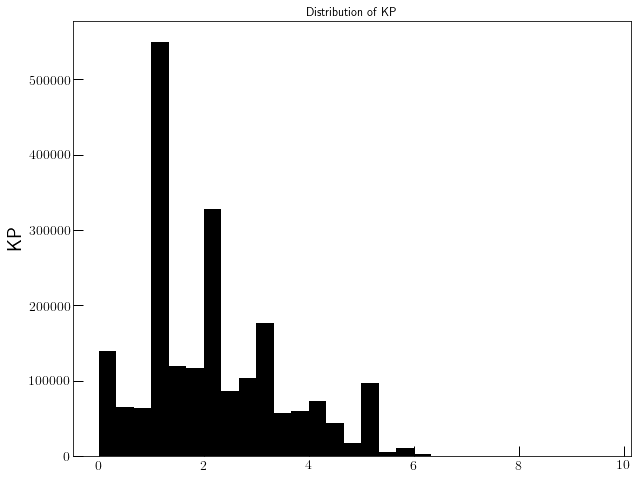

In [21]:
par = 'KP'
toff= int(btab['TIME'].min())
fig = figure(figsize=[10,8])
ylabel(par, fontsize=20)
#xlabel(f'SCC Time - {toff}', fontsize=20)
#plot(btab['TIME']-toff, btab['KP'], 'o')
title(f'Distribution of {par}')
h = hist(btab[par], bins=np.arange(0,30)/3)

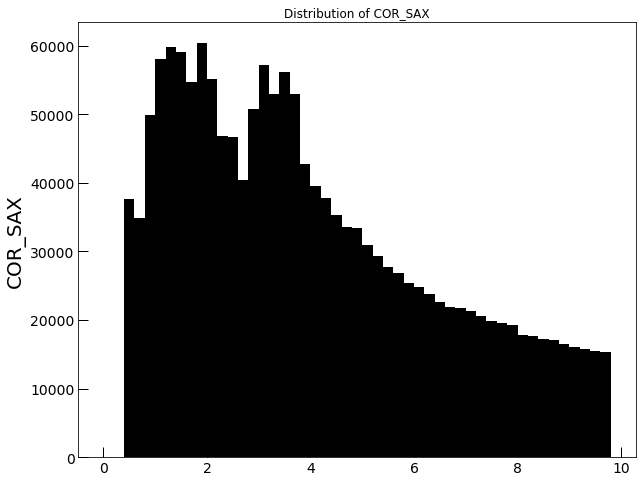

In [29]:
par = 'COR_SAX'
toff= int(btab['TIME'].min())
fig = figure(figsize=[10,8])
ylabel(par, fontsize=20)
#xlabel(f'SCC Time - {toff}', fontsize=20)
#plot(btab['TIME']-toff, btab['KP'], 'o')
title(f'Distribution of {par}')
h = hist(btab[par], bins=np.arange(0,50)/5)


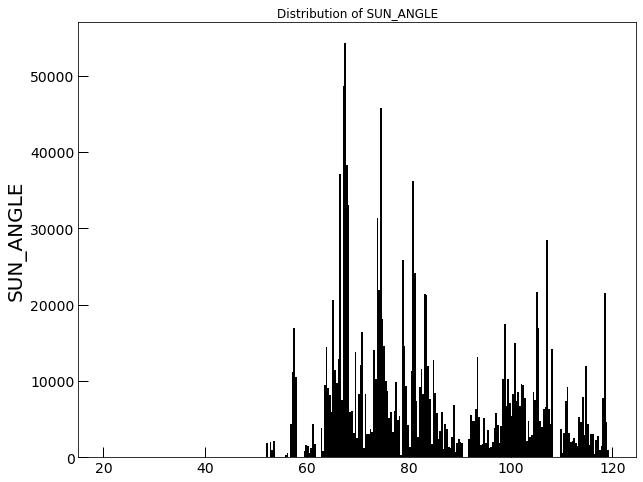

In [34]:
par = 'SUN_ANGLE'
toff= int(btab['TIME'].min())
fig = figure(figsize=[10,8])
ylabel(par, fontsize=20)
#xlabel(f'SCC Time - {toff}', fontsize=20)
#plot(btab['TIME']-toff, btab['KP'], 'o')
title(f'Distribution of {par}')
h = hist(btab[par], bins=np.arange(60,360)/3)


In [38]:
h[1]

array([ 20.        ,  20.33333333,  20.66666667,  21.        ,
        21.33333333,  21.66666667,  22.        ,  22.33333333,
        22.66666667,  23.        ,  23.33333333,  23.66666667,
        24.        ,  24.33333333,  24.66666667,  25.        ,
        25.33333333,  25.66666667,  26.        ,  26.33333333,
        26.66666667,  27.        ,  27.33333333,  27.66666667,
        28.        ,  28.33333333,  28.66666667,  29.        ,
        29.33333333,  29.66666667,  30.        ,  30.33333333,
        30.66666667,  31.        ,  31.33333333,  31.66666667,
        32.        ,  32.33333333,  32.66666667,  33.        ,
        33.33333333,  33.66666667,  34.        ,  34.33333333,
        34.66666667,  35.        ,  35.33333333,  35.66666667,
        36.        ,  36.33333333,  36.66666667,  37.        ,
        37.33333333,  37.66666667,  38.        ,  38.33333333,
        38.66666667,  39.        ,  39.33333333,  39.66666667,
        40.        ,  40.33333333,  40.66666667,  41.  

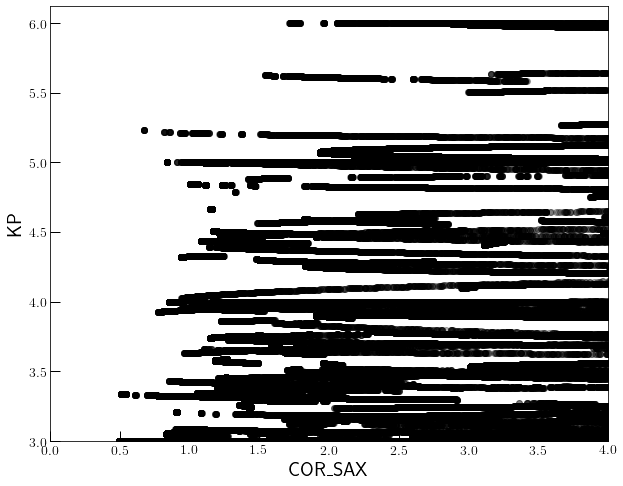

In [36]:
fig = figure(figsize=[10,8])
ylabel('KP', fontsize=20)
xlabel(f'COR\_SAX', fontsize=20)
xlim(0,4)
ylim(3,6.12)
ind = where()
plot(btab['COR_SAX'], btab['KP'], 'o', alpha=.3)

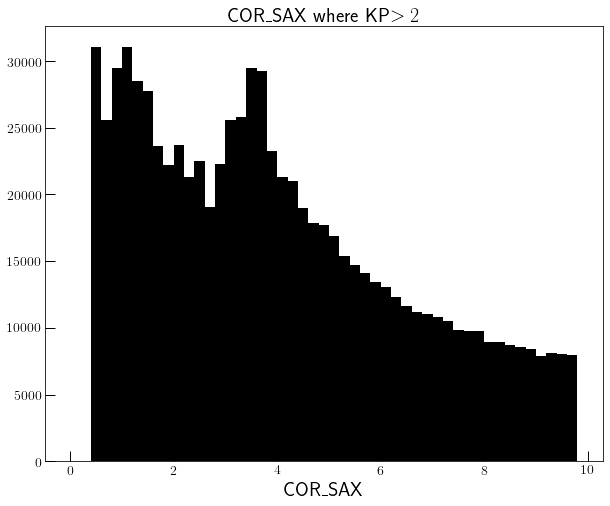

In [10]:
figure(figsize=[10,8])
xlabel('COR\_SAX', fontsize=20)
kpcut = 2
ind = np.where(kp < kpcut)
title(f'COR\_SAX where KP$>{kpcut}$', fontsize=20)
h = hist(btab['COR_SAX'][ind], bins=np.arange(0,50)/5)

## downloading and reading the data from /FTP/caldb/staging/data/nicer/bkgevt_enhanced/work

uses ``pysftp`` and Table

In [11]:
#
# get the distributions of KP, COR_SAX, SUN_ANGLE for the enhanced event files
#
cols = ['KP', 'COR_SAX','SUN_ANGLE']
bins = {'KP':np.arange(0,7), 'COR_SAX':np.arange(0,15), 'SUN_ANGLE':np.arange(0,360,10)}
eevtdict = {}
histod = {}
for file in eevtlist[0:10]:
    lfile = os.path.join('/Volumes/SXDC/tmp/', 'tmp_enhanced.evt')
    print(f"Downloading {file}")
    sftp.get(file, localpath=lfile)
    print("   creating table")
    tab = Table.read(lfile,format='fits', hdu='EVENTS')
    for c in cols:
        h = np.histogram(tab[c], bins=bins[c])
        clf()
        histod[c] = h
        ind = np.where(h[0] > 0)[0]
        print(f'   {c}: Number of non-zero bins = {len(ind)} Min = {min(h[1][ind])}; Max = {max(h[1][ind])}')
    eevtdict[file]=histod
#sftp.close()

NameError: name 'eevtlist' is not defined

In [163]:
h[1]

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190])

In [ ]:
sftp.close()

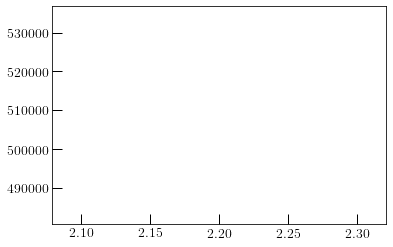

In [133]:
k = list(eevtdict.keys())
h = eevtdict[k[0]]['KP'][0][ind]
ind = np.where(h > 0)[0]
b = eevtdict[k[0]]['KP'][1][1:][ind]
step(b[1:][ind], h[ind])

In [142]:
np.histogram?

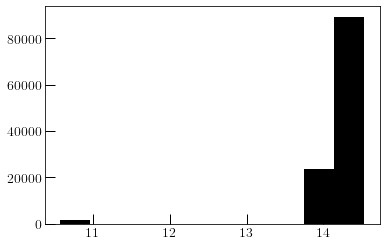

In [108]:
h  = hist(tab['COR_SAX'])

In [107]:
h[0:2]

(array([113038.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1578.]),
 array([110.86530069, 117.36108111, 123.85686153, 130.35264194,
        136.84842236, 143.34420278, 149.83998319, 156.33576361,
        162.83154403, 169.32732444, 175.82310486]))

In [71]:
sftp.get('ni2012080105.mkf2', localpath='/Users/corcoran/tmp/tmp.mkf2')
sftp.close()


In [75]:
tab = Table.read('/Users/corcoran/tmp/tmp.mkf2', format='fits', hdu='PREFILTER')

In [76]:
tab

TIME,POSITION [3],VELOCITY [3],QUATERNION [4],PNTUNIT [3],POLAR [3],RA,DEC,ROLL,SAT_LAT,SAT_LON,SAT_ALT,ELV,BR_EARTH,SUNSHINE,FOV_FLAG,SUN_ANGLE,MOON_ANGLE,RAM_ANGLE,ANG_DIST,SAA,SAA_TIME,COR_ASCA,COR_SAX,MCILWAIN_L,SUN_RA,SUN_DEC,MOON_RA,MOON_DEC,EARTH_RA,EARTH_DEC,TIME_ADJ,ST_BBO,ST_VALID,ST_OBJECTS,ST_VIDEO_VDC,ATT_ANG_AZ,ATT_ANG_EL,RA_CMD,DEC_CMD,ATT_ERR_AZ,ATT_ERR_EL,ATT_STATE,ATT_MODE,ATT_SUBMODE_AZ,ATT_SUBMODE_EL,TARG_CMD,PPS_SOURCE,PPS_ERR_LOWPASS,GPS_INIT,GPS_CONVERGED,NICER_SAA,ST_STARS,ST_FAILCODE,"MPU_ALL_COUNT [7,8]","MPU_OVER_COUNT [7,8]","MPU_UNDER_COUNT [7,8]","MPU_XRAY_COUNT [7,8]",TOT_ALL_COUNT,TOT_UNDER_COUNT,TOT_OVER_COUNT,TOT_XRAY_COUNT,"FPM_ON [7,8]",NUM_FPM_ON,FPM_RATIO_REJ_COUNT,FPM_XRAY_PI_0000_0025,FPM_XRAY_PI_0035_0200,FPM_XRAY_PI_0200_0800,FPM_XRAY_PI_0800_1200,FPM_XRAY_PI_1200_1500,FPM_XRAY_PI_1500_1700,FPM_XRAY_PI_COUNT,MPU_DEADTIME [7],"MPU_DOUBLE_COUNT [7,8]","MPU_FT_COUNT [7,8]","MPU_NOISE25_COUNT [7,8]","MPU_OVERONLY_COUNT [7,8]","MPU_UNDERONLY_COUNT [7,8]",FPM_DOUBLE_COUNT,FPM_OVERONLY_COUNT,FPM_UNDERONLY_COUNT,FPM_FT_COUNT,FPM_NOISE25_COUNT,"MPU_FT_PI_AVG [7,8]","MPU_FT_PI_ERR [7,8]","MPU_FT_PI_FAST_AVG [7,8]","MPU_FT_PI_FAST_ERR [7,8]","MPU_NOISE25_PI_AVG [7,8]","MPU_NOISE25_PI_ERR [7,8]",ISS_ATT_STATE,ROBO_STATE,VEHICLE_SOYUZ_DC1,VEHICLE_SOYUZ_MRM1,VEHICLE_SOYUZ_MRM2,VEHICLE_SOYUZ_SM
s,km,km / s,,,"rad, rad, km",deg,deg,deg,deg,deg,km,deg,deg,,,deg,deg,deg,deg,,s,GeV/c,GeV/c,,deg,deg,deg,deg,deg,deg,s,,,,V,deg,deg,deg,deg,deg,deg,,,,,,,s,,,,,,,,,,,,,,,,,,,,,,,,s,,,,,,,,,,,chan,chan,chan,chan,chan,chan,,,,,,
float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,uint8,uint8,uint8,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint16,uint32,float64,uint8,uint8,uint8,uint8,uint8,int16,int16,int16,int16,int32,int32,int32,int32,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,uint8,uint8,uint8,uint8,uint8
165340827.000000,-275.652 .. 4936.380,-6.781 .. 2.242,-0.87352657 .. 0.48205113,-0.10437138 .. -0.53994256,6780.619 .. 0.8154195,97.123032,-32.679729,179.07,46.7201,26.5262,6780.619,30.37,30.37,1,0,91.29,122.54,111.71,113.7582,0,-999.0,8.98,4.11,1.99,7.725443,3.335985,296.570770,-21.694103,273.399567,-46.720097,165340825.0,0,0,0,2.502,-27.83524,106.83335,183.70000,53.30000,135.31163,16.97444,1,1,1,1,506,1,1.9062290629114995e-09,1,1,0,0,32,0 .. 0,0 .. 0,0 .. 0,0 .. 0,0,0,0,0,False .. False,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000 .. 0.000000,0 .. 0,0 .. 0,0 .. 0,0 .. 0,0 .. 0,nan,nan,nan,0.00,0.00,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,+XVV,0,0,1,0,0
165340828.000000,-282.433 .. 4938.619,-6.780 .. 2.235,-0.87250549 .. 0.48309016,-0.12109247 .. -0.53692877,6780.614 .. 0.815902,98.252617,-32.474812,179.92,46.7477,26.6075,6780.614,30.50,30.50,1,0,92.23,123.07,110.76,112.9842,0,-999.0,8.98,4.10,1.99,7.725454,3.335989,296.572021,-21.694355,273.485077,-46.747738,165340826.0,0,0,0,3.010,-26.75251,107.02381,183.70000,53.30000,134.29892,16.84227,1,1,1,1,506,1,1.9062290629114995e-09,1,1,0,0,32,0 .. 0,0 .. 0,0 .. 0,0 .. 0,0,0,0,0,False .. False,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000 .. 0.000000,0 .. 0,0 .. 0,0 .. 0,0 .. 0,0 .. 0,nan,nan,nan,0.00,0.00,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,+XVV,0,0,1,0,0
165340829.000000,-289.213 .. 4940.851,-6.780 .. 2.229,-0.87137049 .. 0.48421100,-0.13746805 .. -0.53348249,6780.6084 .. 0.81638336,99.353668,-32.241055,180.77,46.7753,26.6889,6780.608,30.65,30.65,1,0,93.15,123.61,109.82,112.2059,0,-999.0,8.98,4.09,1.99,7.725465,3.335992,296.573273,-21.694607,273.570679,-46.775322,165340827.0,0,0,0,3.596,-25.83374,107.216

## Bkg Observations combined MKF file

* We could make an mkf file combined for all the obsids for the bkg observations (including an obsid column)
* we could then examine the KP, SUN_ANGLE, COR_SAX values from the MKF file for the observation of the target observation
 * We could then determine the distribution of SUN_ANGLE for a given COR_SAX interval for a given KP interval in the target observation
 * we could then examine the BKG combined MKF file to extract the BKG data obsids which match those (SA, CS, KP) ranges and filter the bkg events from those obsids 